The code in this file corresponds to the implementation of Fig. 6 in the paper.
This script requires the following Python dependencies:
- numpy
- matplotlib

1. Case without any QEC

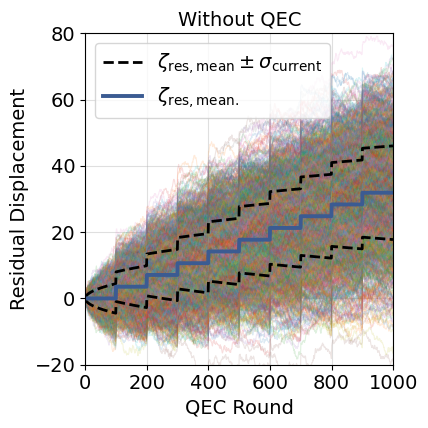

In [5]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.size": 14,        # global font size
    "axes.labelsize": 14,   # axis label size
    "axes.titlesize": 14,   # title size
    "xtick.labelsize": 14,  # x tick size
    "ytick.labelsize": 14,  # y tick size
    "legend.fontsize": 14,  # legend size
})

sigma = np.sqrt(0.2)
num_rounds = 999
num_traj = 2000

jump_period = 100
jump_amp = 2 * np.sqrt(np.pi)

# Figure size
plt.figure(figsize=(4.5, 4.5))

# Soft color palette
colors = plt.cm.tab10(np.linspace(0, 1, 10))

for i in range(num_traj):
    steps = np.random.normal(0, sigma, num_rounds)
    jump_indices = np.arange(jump_period - 1, num_rounds, jump_period)
    steps[jump_indices] += jump_amp
    x = np.cumsum(steps)

    # Color cycle + transparency
    c = colors[i % 10]
    plt.plot(range(1, num_rounds + 1), x, color=c, alpha=0.15, linewidth=0.8)

# Theoretical bounds and mean
n = np.arange(1, num_rounds + 1)
jump_counts = np.floor(n / jump_period)
drift = jump_amp * jump_counts
spread = sigma * np.sqrt(n)

upper = drift + spread
lower = drift - spread

plt.plot(n, upper, 'k--', linewidth=2, label=r'$\zeta_{\mathrm{res,mean}}\pm\sigma_{\mathrm{current}}$')
plt.plot(n, lower, 'k--', linewidth=2)
plt.plot(n, drift, color='#3B5B92', linewidth=2.8, label=r'$\zeta_{\mathrm{res,mean}.}$')

plt.xlabel('QEC Round')
plt.ylabel('Residual Displacement')
plt.title('Without QEC')
plt.legend()
plt.grid(True, alpha=0.4)

# Fixed axis limits
plt.ylim(-20, 80)
plt.xlim(0, 1000)

plt.tight_layout()
plt.show()

2. Only Gaussian noise suppression

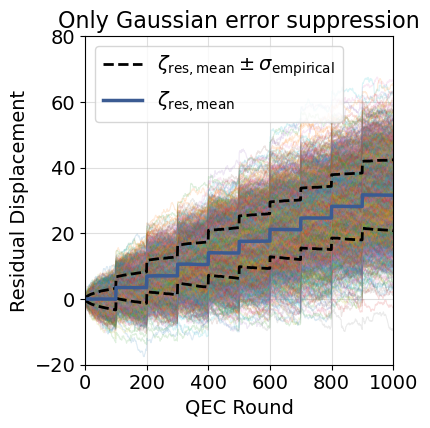

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# ===== Global plotting style =====
plt.rcParams.update({
    "font.size": 14,        # global font size
    "axes.labelsize": 14,   # axis label size
    "axes.titlesize": 16,   # title size
    "xtick.labelsize": 14,  # x-tick size
    "ytick.labelsize": 14,  # y-tick size
    "legend.fontsize": 14,  # legend size
})

# ===== Simulation parameters =====
var = 0.2
sigma = np.sqrt(var)
num_rounds = 999
num_traj = 2000

L = 2 * np.sqrt(np.pi)          # GKP lattice period
jump_period = 100               # one abrupt jump every 100 rounds
jump_amp = 2 * np.sqrt(np.pi)   # jump amplitude (+2√π)

def wrap_to_min_abs(x, L):
    """Map x to (-L/2, L/2]."""
    return ((x + L/2) % L) - L/2

# ===== Simulation: Gaussian suppression + periodic abrupt jumps =====
all_traj = np.zeros((num_traj, num_rounds))

for t in range(num_traj):
    d = 0.0   # data mode residual displacement
    g = 0.0   # GKP ancilla cumulative noise
    for n in range(num_rounds):
        # Gaussian noise
        delta_d = np.random.normal(0.0, sigma)
        delta_g = np.random.normal(0.0, sigma)
        d += delta_d
        g += delta_g

        # periodic abrupt jump on data mode
        if (n + 1) % jump_period == 0:
            d += jump_amp

        # GKP syndrome and correction
        s = d + g
        s_mod = wrap_to_min_abs(s, L)
        corr = s_mod / 2.0
        d -= corr
        g -= corr

        all_traj[t, n] = d

# ===== Statistics over trajectories: mean and std per round =====
mean_round = np.mean(all_traj, axis=0)   # shape: (num_rounds,)
std_round = np.std(all_traj, axis=0)     # shape: (num_rounds,)

# ===== Plot: trajectories + empirical envelope + mean line =====
rounds = np.arange(1, num_rounds + 1)

plt.figure(figsize=(4.5, 4.5))

# sample trajectories (faded, multi-color)
colors = plt.cm.tab10(np.linspace(0, 1, 10))
for t in range(num_traj):
    c = colors[t % 10]
    plt.plot(rounds, all_traj[t], color=c, alpha=0.15, linewidth=0.8)

# empirical envelope: mean ± std
upper_bound = mean_round + std_round
lower_bound = mean_round - std_round

plt.plot(
    rounds,
    upper_bound,
    'k--',
    linewidth=2.0,
    label=r'$\zeta_{\mathrm{res,mean}}\pm\sigma_{\mathrm{empirical}}$',
)
plt.plot(rounds, lower_bound, 'k--', linewidth=2.0)

# mean residual displacement
plt.plot(
    rounds,
    mean_round,
    color='#3B5B92',
    linewidth=2.5,
    label=r'$\zeta_{\mathrm{res,mean}}$',
)

# ===== Axes and labels =====
plt.xlim(0, 1000)
plt.ylim(-20, 80)

plt.xlabel('QEC Round')
plt.ylabel('Residual Displacement')
plt.title('Only Gaussian error suppression')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()


3. Case of concatenated code

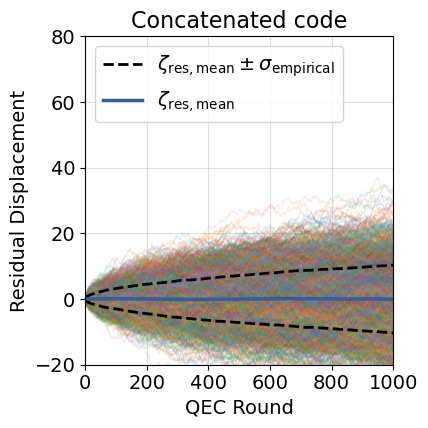

In [7]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.size": 14,        # global font size
    "axes.labelsize": 14,   # axis label size
    "axes.titlesize": 16,   # title size
    "xtick.labelsize": 14,  # x-tick size
    "ytick.labelsize": 14,  # y-tick size
    "legend.fontsize": 14,  # legend size
})

# ===== Parameters =====
var = 0.2
sigma = np.sqrt(var)          # noise std
num_rounds = 999              # total rounds
num_traj = 2000               # number of trajectories

jump_period = 100             # abrupt jump interval
jump_amp = 2 * np.sqrt(np.pi) # jump amplitude (+2√π)

# ===== Simulation: CV Steane (linear Gaussian suppression, no modulo) =====
all_traj = np.zeros((num_traj, num_rounds))

for t in range(num_traj):
    d = 0.0   # data mode residual
    g = 0.0   # ancilla mode residual

    for n in range(num_rounds):
        # Gaussian noise
        delta_d = np.random.normal(0.0, sigma)
        delta_g = np.random.normal(0.0, sigma)

        d += delta_d
        g += delta_g

        # abrupt jump applied to both modes
        if (n + 1) % jump_period == 0:
            d += jump_amp
            g += jump_amp

        # linear syndrome and correction
        s = d + g
        corr = s / 2.0
        d -= corr
        g -= corr

        all_traj[t, n] = d

# ===== Empirical statistics =====
mean_round = np.mean(all_traj, axis=0)
std_round  = np.std(all_traj, axis=0)

# ===== Plot =====
rounds = np.arange(1, num_rounds + 1)
plt.figure(figsize=(4.5, 4.5))

# sample trajectories
colors = plt.cm.tab10(np.linspace(0, 1, 10))
for t in range(num_traj):
    c = colors[t % 10]
    plt.plot(rounds, all_traj[t], alpha=0.15, lw=0.8, color=c)

# envelope: mean ± std
upper = mean_round + std_round
lower = mean_round - std_round

plt.plot(
    rounds,
    upper,
    'k--',
    linewidth=2.0,
    label=r'$\zeta_{\mathrm{res,mean}}\pm\sigma_{\mathrm{empirical}}$'
)
plt.plot(rounds, lower, 'k--', linewidth=2.0)

# mean residual
plt.plot(
    rounds,
    mean_round,
    color='#3B5B92',
    linewidth=2.5,
    label=r'$\zeta_{\mathrm{res,mean}}$'
)

plt.xlabel('QEC Round')
plt.ylabel('Residual Displacement')
plt.title('Concatenated code')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.4)

# fixed axis range
plt.xlim(0, 1000)
plt.ylim(-20, 80)

plt.tight_layout()
plt.show()